In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Dataset

In [2]:
dataset='bone_tumor'

from data.loader import DataLoader
dl = DataLoader()
train_primitive_matrix, val_primitive_matrix, test_primitive_matrix, \
train_ground, val_ground, test_ground = dl.load_data(dataset=dataset)

## Synthesis + Verification
Generate functions based on feedback from the verifier (vary cardinality)

In [ ]:
#import time
#start = time.time()

from program_synthesis.heuristic_generator import HeuristicGenerator
validation_accuracy = []
training_accuracy = []
validation_coverage = []
training_coverage = []

training_marginals = []
idx = None

hg = HeuristicGenerator(train_primitive_matrix, val_primitive_matrix, 
                            val_ground, train_ground, 
                            b=0.5)
for i in range(3,10):
    if i == 3:
        hg.run_synthesizer(max_cardinality=3, idx=idx, keep=3, model='lr')
    else:
        hg.run_synthesizer(max_cardinality=3, idx=idx, keep=1, model='lr')
    hg.run_verifier()
    
    va,ta, vc, tc = hg.evaluate()
    validation_accuracy.append(va)
    training_accuracy.append(ta)
    training_marginals.append(hg.vf.train_marginals)
    validation_coverage.append(vc)
    training_coverage.append(tc)
    
    #idx=None
    
    hg.find_feedback()
    idx = hg.feedback_idx
    
    
    if idx == []:
        break

    #print 'Time Elapsed: ', time.time() - start

### Visualize Heuristic Behavior

In [5]:
hg.heuristic_stats()

,Feat 1,Feat 2,Val Acc,Train Acc,Val Cov,Train Cov
0,9.0,12.0,0.635,0.6750,0.355,0.3300
1,9.0,14.0,0.645,0.6775,0.340,0.3350
2,5.0,9.0,0.645,0.6550,0.350,0.3125
3,5.0,12.0,0.620,0.6150,0.430,0.3850
4,9.0,12.0,0.690,0.6625,0.560,0.5175
5,6.0,12.0,0.680,0.6725,0.500,0.4175
6,6.0,12.0,0.665,0.6750,0.500,0.4225
7,9.0,12.0,0.650,0.6750,0.510,0.4625
8,9.0,12.0,0.650,0.6700,0.455,0.4125


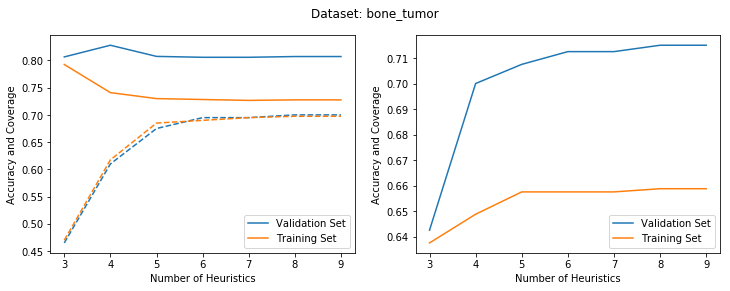

In [9]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(3,10),validation_accuracy, color='C0')
plt.plot(range(3,10),training_accuracy, color='C1')
plt.plot(range(3,10),validation_coverage, color='C0', linestyle='--')
plt.plot(range(3,10),training_coverage, color='C1', linestyle='--')
plt.legend(['Validation Set', 'Training Set'])
plt.xlabel('Number of Heuristics')
plt.ylabel('Accuracy and Coverage')
#plt.ylim([0.55,1.0])

plt.subplot(1,2,2)
bm = [(a*b) + (0.5*(1-b)) for a,b in zip(validation_accuracy,validation_coverage)] 
plt.plot(range(3,10),bm, color='C0')
bm = [(a*b) + (0.5*(1-b)) for a,b in zip(training_accuracy,training_coverage)] 
plt.plot(range(3,10),bm, color='C1')
plt.legend(['Validation Set', 'Training Set'])
plt.xlabel('Number of Heuristics')
plt.ylabel('Accuracy and Coverage')
#plt.ylim([0.55,1.0])
plt.suptitle('Dataset: ' + dataset)

In [ ]:
print "Program Synthesis Train Accuracy: ", np.max(training_accuracy[1:])
print "Program Synthesis Train Coverage: ", training_coverage[1:][np.argmax(training_accuracy[1:])]
print "Number of Heuristics: ", np.argmax(training_accuracy[1:])+4

print "Program Synthesis Validation Accuracy: ", np.max(validation_accuracy[1:])

### Save Reef Marginals

In [106]:
filepath = '/dfs/scratch0/paroma/reef/' + dataset
np.save(filepath+'_reef_lr5.npy', training_marginals[1])

In [ ]:
# beta_opt = hg.syn.find_optimal_beta(hg.hf, hg.val_primitive_matrix, hg.feat_combos, hg.val_ground)
# L_train_all = hg.apply_heuristics(hg.hf, primitive_matrix, hg.feat_combos, beta_opt)

# from program_synthesis.verifier import Verifier
# vf_temp = Verifier(L_train_all,L_train_all,train_ground)
# vf_temp.train_gen_model()
# vf_temp.assign_marginals()
# training_all = vf_temp.train_marginals

# filepath = '/dfs/scratch0/paroma/reef/' + dataset
# np.save(filepath+'_reef_nn1.npy', training_all)

## Calculate Baselines

In [3]:
# primitive_matrix = np.load('./data/mammogram/primitive_matrix.npy')
# primitive_matrix = primitive_matrix.T

[**Decision Tree**](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
Depth bound is unbounded, using default settings. Could do a finer comparison if needed.

In [4]:
from baselines.models import DecisionTree
dt = DecisionTree(train_primitive_matrix, val_primitive_matrix, 
                            val_ground, train_ground)
dt.fit()
va,ta, vc, tc = dt.evaluate()
print "Decision Tree Train Accuracy: ", ta
print "Decision Tree Validation Accuracy: ", va

Decision Tree Train Accuracy:  0.6447034214851337
Decision Tree Validation Accuracy:  1.0


[**Boosting (AdaBoost)**](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier) No bound of the number of estimators yet, could bound by number of primitives for "fair" comparison?

In [6]:
from baselines.models import BoostClassifier
bc = BoostClassifier(train_primitive_matrix, val_primitive_matrix, 
                            val_ground, train_ground)
bc.fit()
va,ta, vc, tc = bc.evaluate()
print "Boosting Train Accuracy: ", ta
print "Boosting Validation Accuracy: ", va

Boosting Train Accuracy:  0.7179889436724937
Boosting Validation Accuracy:  0.720902435380248


[**LabelPropagation (Normal Semi-Supervised)**](http://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html#sklearn.semi_supervised.LabelSpreading)
Semi-supervised method that is robust to noise. Fits with both the labeled and unlabeled examples

In [7]:
from baselines.models import SemiSupervised
ss = SemiSupervised(train_primitive_matrix, val_primitive_matrix, 
                            val_ground, train_ground)
ss.fit()
va,ta, vc, tc = ss.evaluate()
print "SemiSupervised Train Accuracy: ", ta
print "SemiSupervised Validation Accuracy: ", va

SemiSupervised Train Accuracy:  0.6529583146571044
SemiSupervised Validation Accuracy:  0.7876886299118482


[**CPLE (Pessimistic Likelihood Estimation for Semi-Supervised)**](https://github.com/tmadl/semisup-learn) Based on the [model](https://arxiv.org/abs/1503.00269) that guarantees that adding in the unlabeled data points will not worsen only training with labeled examples

In [8]:
from baselines.models import ContrastiveSemiSupervised
css = ContrastiveSemiSupervised(train_primitive_matrix, val_primitive_matrix, 
                            val_ground, train_ground)
css.fit()
va,ta, vc, tc = css.evaluate()
print "ContrastiveSemiSupervised Train Accuracy: ", ta
print "ContrastiveSemiSupervised Validation Accuracy: ", va

.n...n..n.nn converged.
ContrastiveSemiSupervised Train Accuracy:  0.5107201553862244
ContrastiveSemiSupervised Validation Accuracy:  0.5111310324219334


### Save Baseline Marginals

In [9]:
filepath = '/dfs/scratch0/paroma/reef/' + dataset

np.save(filepath+'_dt.npy', dt.train_marginals)
np.save(filepath+'_bc.npy', bc.train_marginals)
np.save(filepath+'_ss.npy', ss.train_marginals)
np.save(filepath+'_css.npy', css.train_marginals)

np.save(filepath+'_gt.npy', train_ground)